# Vertex Pipelines: AutoML Tabular pipelines using google-cloud-pipeline-components


## Overview


This notebook shows how to use the components defined in [`google_cloud_pipeline_components`](https://github.com/kubeflow/pipelines/tree/master/components/google-cloud) to build an AutoML Tabular workflow on [Vertex Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines).

### Objective

In this example, you'll learn how to use components from `google_cloud_pipeline_components` to:
- create a _Dataset_ using a BigQuery Table
- train an AutoML Tabular model
- deploy the trained model to an _endpoint_ for serving

The components are [documented here](https://google-cloud-pipeline-components.readthedocs.io/en/latest/google_cloud_pipeline_components.aiplatform.html#module-google_cloud_pipeline_components.aiplatform).

### Costs 

This tutorial uses billable components of Google Cloud:

* Vertex AI Training and Serving
* Cloud Storage
* BigQuery Table


### Set up your  development environment

**Please note that the environment for the following notebook steps can be run on Google Cloud Notebooks**, your environment already meets
all the requirements to run this notebook.

### Install additional packages


In [ ]:
!pip3 install -q google-cloud-aiplatform==1.0.0 --upgrade
!pip3 install -q kfp google-cloud-pipeline-components==0.1.1 --upgrade

In [ ]:
!pip3 install -q google-cloud-storage==1.32.0


### Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [ ]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

Check the versions of the packages you installed.  The KFP SDK version should be >=1.6.

In [ ]:
#test the version of Kfp - should be >= 1.6

import kfp
print('KFP SDK version: {}'.format(kfp.__version__))

## Before you begin

This notebook does not require a GPU runtime.

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI, Cloud Storage, and Compute Engine APIs](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component,storage-component.googleapis.com). 

1. Follow the "**Configuring your project**" instructions from the Vertex Pipelines documentation.

1. If you are running this notebook locally, you will need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [ ]:
import os

PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)


Otherwise, set your project ID here.

In [ ]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "<CHANGE_THIS>"  # @param {type:"string"}

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append it onto the name of resources you create in this tutorial.

In [ ]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Authenticate your Google Cloud account

**Ensure that you are using Google Cloud Notebooks**, where your environment is already
authenticated. 

### Create a Cloud Storage bucket as necessary

You will need a Cloud Storage bucket for this example.  If you don't have one that you want to use, you can make one now.


Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets.

You may also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Vertex AI services are
available](https://cloud.google.com/vertex-ai/docs/general/locations#available_regions). You may
not use a Multi-Regional Storage bucket for training with Vertex AI.

In [ ]:
#BUCKET_NAME = "gs://project849089-bucket/vai"  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"}
BUCKET_NAME = "gs://" + PROJECT_ID + "_vertex_aip_" + TIMESTAMP

print(BUCKET_NAME)

In [ ]:
! gsutil mb -l $REGION $BUCKET_NAME

Finally, validate access to your Cloud Storage bucket by examining its contents:

In [ ]:
! gsutil ls -al $BUCKET_NAME

### Import libraries and define constants

Define some constants. 


In [ ]:
PATH=%env PATH
%env PATH={PATH}:/home/jupyter/.local/bin

USER = "automl_classification"  # <---CHANGE THIS
PIPELINE_ROOT = "{}/pipeline_root/{}".format(BUCKET_NAME, USER)

PIPELINE_ROOT

Do some imports:

In [ ]:
import uuid

import kfp
from google.cloud import aiplatform
from google_cloud_pipeline_components import aiplatform as gcc_aip
from kfp.v2 import compiler
from kfp.v2.google.client import AIPlatformClient



In [ ]:
project=PROJECT_ID
bq_source_tbl = "bq://"+project+".telco.churn"
print(bq_source_tbl)

## Define an AutoML Tabular classification pipeline that uses components from google_cloud_pipeline_components

Create a dataset from a BigQuery Table and train it using AutoML Tabular Training.


Define the pipeline:

Pipeline module consists of 3 tasks / operations: 

1- **Create dataset task:** A dataset with the display name will be created under the dataset options in Vertex AI Screen

2- **Create training run task:** A Tabular Training Job is defined, with the dataset, prediction_type, optimization objectives and the target_column. 

3- **Model deploy task:** Model deployment task with project name and machine_type. Please note that the parameter machine_type is mandatory.

In [ ]:
@kfp.dsl.pipeline(name="automl-classification-training-v2" + str(uuid.uuid4()))
def pipeline(project: str = PROJECT_ID):

    dataset_create_task = gcc_aip.TabularDatasetCreateOp(
        display_name="dataset_automl_churn_kfp",
        bq_source=bq_source_tbl,
        project=project,
    )
            
    training_run_task = gcc_aip.AutoMLTabularTrainingJobRunOp(
        dataset=dataset_create_task.outputs["dataset"],
        display_name="train_automl_churn_kfp",
        optimization_prediction_type="classification",
        optimization_objective = "minimize-log-loss",
        training_fraction_split=0.6,
        validation_fraction_split=0.2,
        test_fraction_split=0.2,
        model_display_name="model_automl_churn_kfp",
        project=project,
        target_column="Churn"
    )

    model_deploy_op = gcc_aip.ModelDeployOp(  # noqa: F841
        model=training_run_task.outputs["model"], 
        project=project,
        machine_type="n1-standard-4"
    )

## Compile and run the pipeline

Now, you're ready to compile the pipeline:

In [ ]:
from kfp.v2 import compiler  # noqa: F811

compiler.Compiler().compile(
    pipeline_func=pipeline, package_path="tab_classification_pipeline.json"
)

In [ ]:
from kfp.v2.google.client import AIPlatformClient  # noqa: F811

api_client = AIPlatformClient(
    project_id=project,
    region=REGION,
)

In [ ]:
print(PIPELINE_ROOT)

Then, you run the defined pipeline like this: 

In [ ]:
response = api_client.create_run_from_job_spec(
    "tab_classification_pipeline.json",
    pipeline_root=PIPELINE_ROOT,
    parameter_values={"project": PROJECT_ID},
)

Click on the generated link to see your run in the Cloud Console.  It should look something like this as it is running:

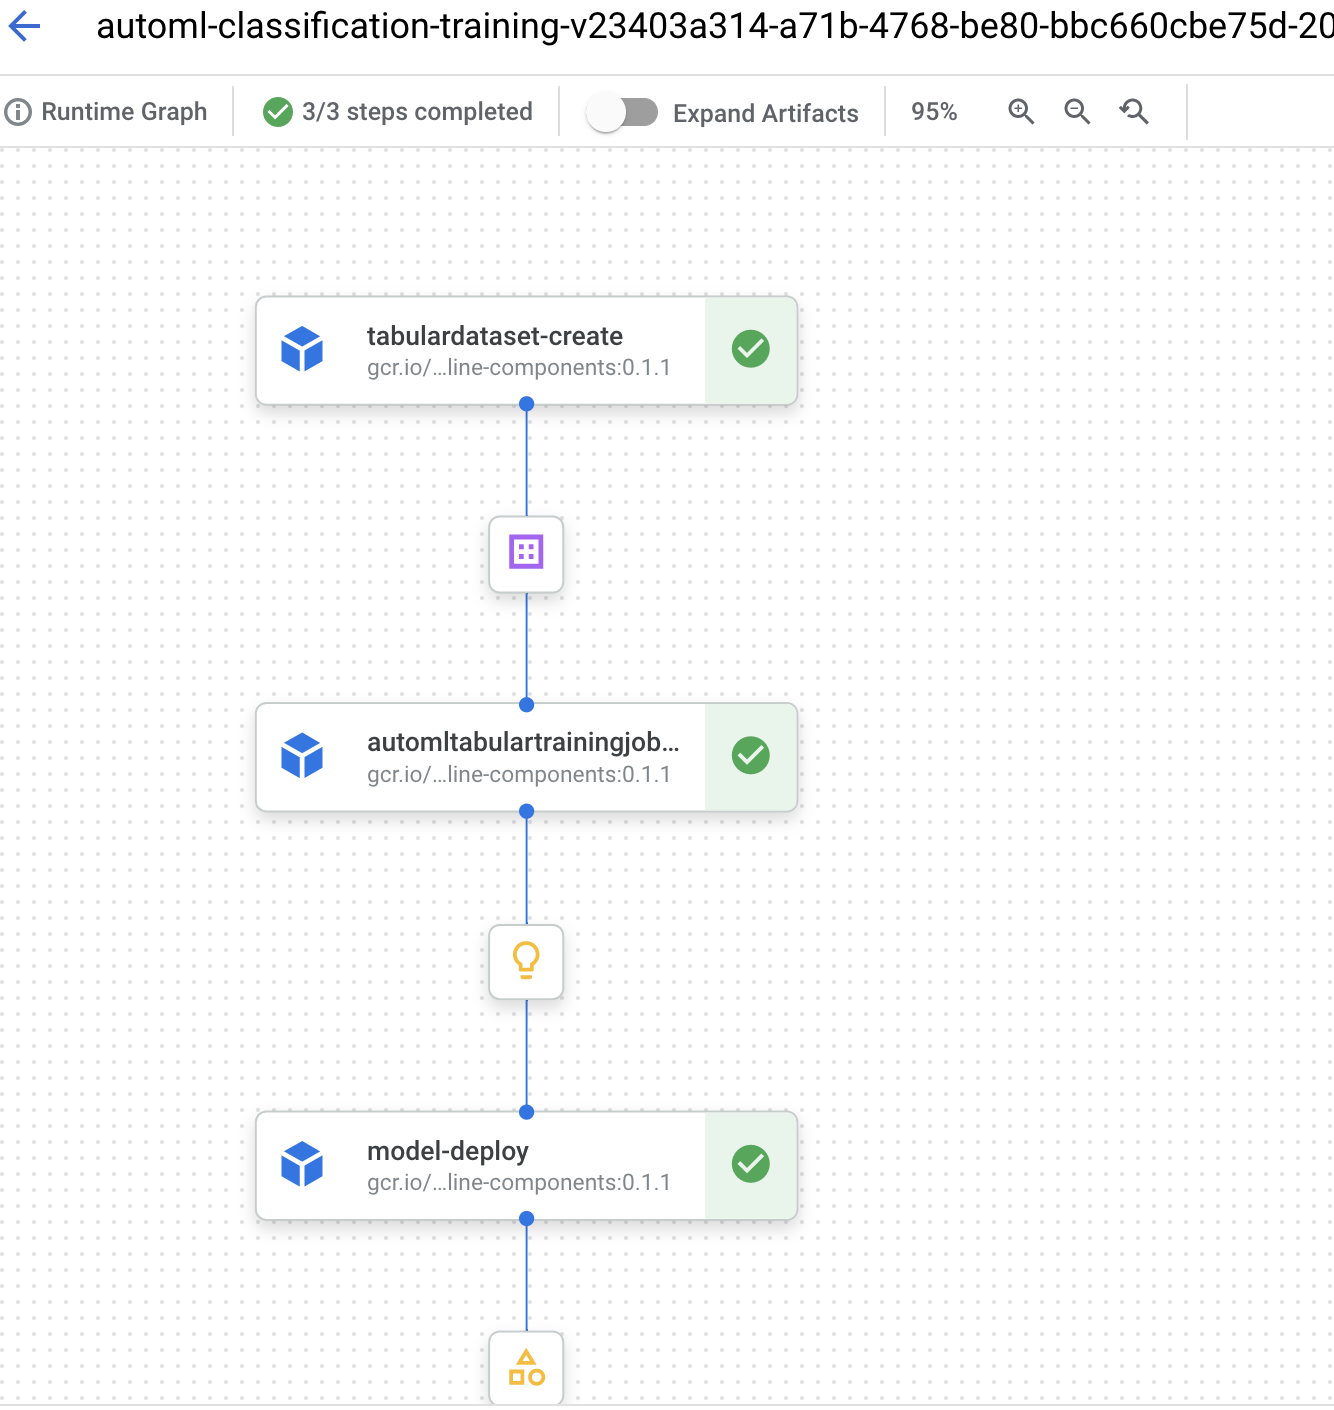

## Observe

Observe the corresponding entries in the dataset, pipeline and models from the Vertex AI interface.



In this example, you learnt how to use components from `google_cloud_pipeline_components` to:
- create a _Dataset_ using a BigQuery Table
- train an AutoML Tabular model
- deploy the trained model to an _endpoint_ for serving
 




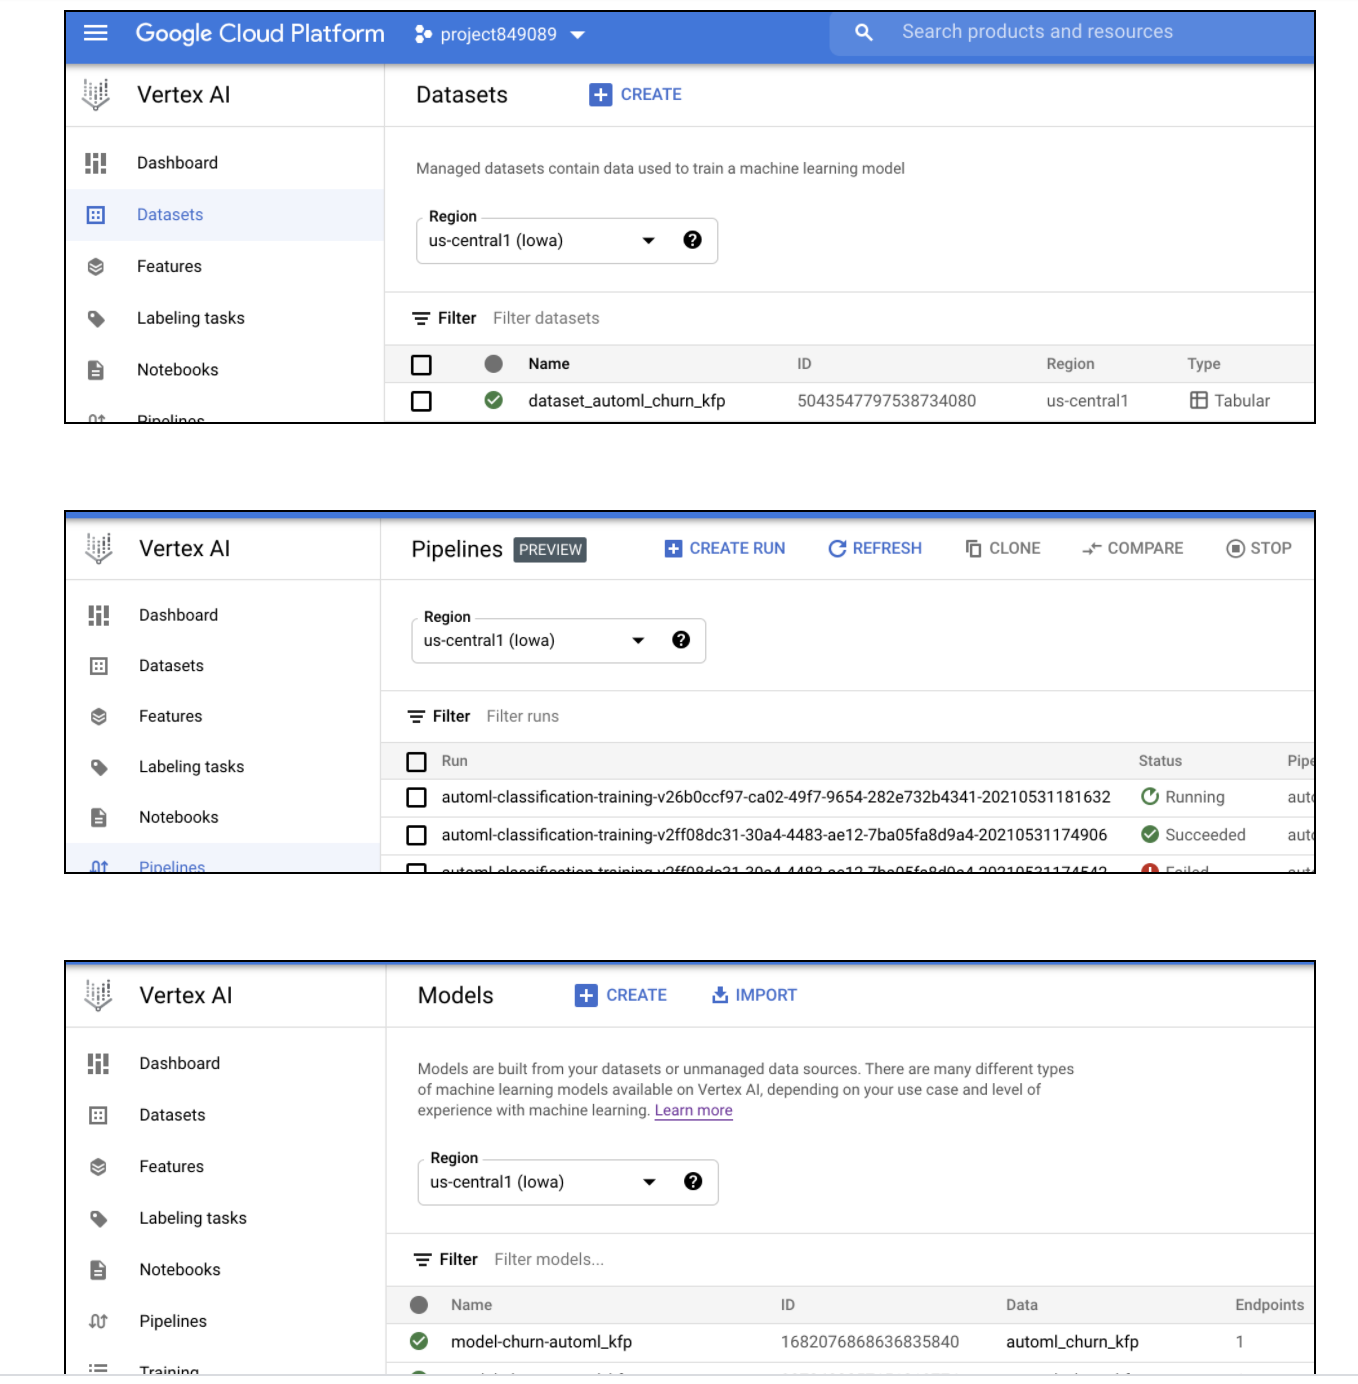

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:
- Delete Cloud Storage objects that were created.  Uncomment and run the command in the cell below **only if you are not using the `PIPELINE_ROOT` path for any other purpose**.
- Delete your deployed model: first, undeploy it from its *endpoint*, then delete the model and endpoint.


In [ ]:
# Warning: this command will delete ALL Cloud Storage objects under the PIPELINE_ROOT path.
# ! gsutil -m rm -r $PIPELINE_ROOT

In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.